## Predict sea ice concentration with sea surface flux using transformer with multi-head attention
This notebook serves as an example of a basic workflow of data driven forecasting using deep learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with multi-head attention transformer. <br>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (`era5cli`) (TBA)
- Map the calendar to the data (`lilio`)
- Train-validate-test split (60%/20%/20%) (`torch`)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Create transformer model (`torch`)
- Specify hyper-parameters (`wandb`)
- Train model (`torch`)
- Evaludate model

In [1]:
import lilio
import numpy as np
import sys
import time as tt
import wandb
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as f

sys.path.append("../src/")
from transformer import Transformer
import utils

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01")
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 8
for _ in range(periods_of_interest):
    calendar.add_intervals("precursor", "15d", gap="15d")

In [3]:
# check calendar
calendar

Calendar(
    anchor='08-01',
    allow_overlap=False,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='0d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d'),
        Interval(role='precursor', length='15d', gap='15d')
    ]
)

#### Download SST and T2M from ERA5 using `era5cli` and prepare input data
(we skip this step for now and use the data we already have.)

In [ ]:
# before executing the fetch request, make sure that you have your ID and key
# check this doc if not https://era5cli.readthedocs.io/en/latest/instructions.html#register-at-copernicus-climate-data-service
# download land variables
#!era5cli hourly --variables 2m_temperature sea_surface_temperature volumetric_soil_water_layer_1 --startyear 2000 --endyear 2010 --area 50 175 35 240

In [4]:
# load data
data_folder = '~/AI4S2S/data'
precursor_field = xr.open_dataset(Path(data_folder, 'sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc'))
target_field = xr.open_dataset(Path(data_folder,'tf5_nc5_dendo_80d77.nc'))

#### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

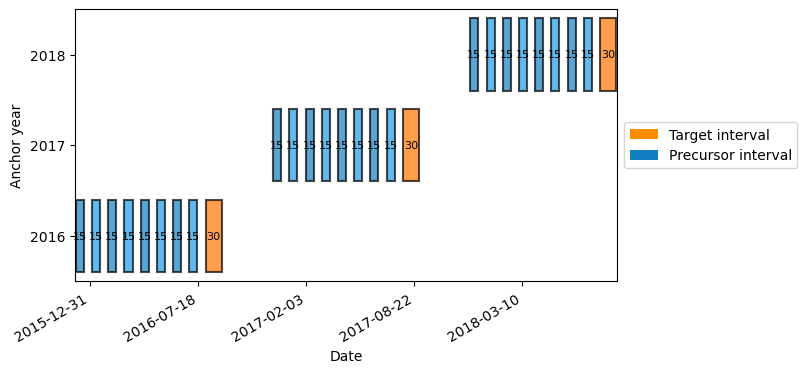

In [5]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [6]:
calendar.show()[:5]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2018,"[2017-12-04, 2017-12-19)","[2018-01-03, 2018-01-18)","[2018-02-02, 2018-02-17)","[2018-03-04, 2018-03-19)","[2018-04-03, 2018-04-18)","[2018-05-03, 2018-05-18)","[2018-06-02, 2018-06-17)","[2018-07-02, 2018-07-17)","[2018-08-01, 2018-08-31)"
2017,"[2016-12-04, 2016-12-19)","[2017-01-03, 2017-01-18)","[2017-02-02, 2017-02-17)","[2017-03-04, 2017-03-19)","[2017-04-03, 2017-04-18)","[2017-05-03, 2017-05-18)","[2017-06-02, 2017-06-17)","[2017-07-02, 2017-07-17)","[2017-08-01, 2017-08-31)"
2016,"[2015-12-05, 2015-12-20)","[2016-01-04, 2016-01-19)","[2016-02-03, 2016-02-18)","[2016-03-04, 2016-03-19)","[2016-04-03, 2016-04-18)","[2016-05-03, 2016-05-18)","[2016-06-02, 2016-06-17)","[2016-07-02, 2016-07-17)","[2016-08-01, 2016-08-31)"
2015,"[2014-12-04, 2014-12-19)","[2015-01-03, 2015-01-18)","[2015-02-02, 2015-02-17)","[2015-03-04, 2015-03-19)","[2015-04-03, 2015-04-18)","[2015-05-03, 2015-05-18)","[2015-06-02, 2015-06-17)","[2015-07-02, 2015-07-17)","[2015-08-01, 2015-08-31)"
2014,"[2013-12-04, 2013-12-19)","[2014-01-03, 2014-01-18)","[2014-02-02, 2014-02-17)","[2014-03-04, 2014-03-19)","[2014-04-03, 2014-04-18)","[2014-05-03, 2014-05-18)","[2014-06-02, 2014-06-17)","[2014-07-02, 2014-07-17)","[2014-08-01, 2014-08-31)"


#### Train-validate-test split based on the anchor years (60%/20%/20% split)

In [7]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
Remove trend and take anomalies for the precursor field.

In [8]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(precursor_field.sel(time=slice(str(start_year),
                                                str(start_year + train_samples - 1))))

In [9]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

Resample data to the calendar

In [10]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [11]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['ts'].sel(cluster=3)

In [12]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)
y_torch = y_torch.unsqueeze(1).unsqueeze(1).repeat(1, 1, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

In [13]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

#### Hyper-parameter tuning with W&B
System info and syncronize training information with W&B server.

In [14]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Pytorch version 1.12.1
Is CUDA available? False
Device to be used for computation: cpu


wandb: Currently logged in as: git-yang (ai4s2s). Use `wandb login --relogin` to force relogin


True

Define hyperparameters and initialize config for wandb.

In [15]:
# call weights & biases service
wandb.login()

hyperparameters = dict(
    epoch = 10,
    num_encoder_layers = 1,
    num_decoder_layers = 1,
    dim_model = lat_precursor*lon_precursor,
    num_heads = 2,
    dim_feedforward = 12,
    batch_size = 4,
    dropout = 0.1,
    learning_rate = 0.001,
    dataset = 'Weather',
    architecture = 'Transformer'
)

# initialize weights & biases service
#mode = 'online'
mode = 'disabled'
wandb.init(config=hyperparameters, project='test-transformer', entity='ai4s2s', mode=mode)
config = wandb.config

In [16]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

#### Initialize and train model
Create transformer. Initialize model and choose loss function and optimizer.

In [17]:
# Initialize model
model = Transformer(num_encoder_layers = config["num_encoder_layers"],
                    num_decoder_layers = config["num_decoder_layers"],
                    dim_model = config["dim_model"], 
                    num_heads = config["num_heads"], 
                    dim_feedforward = config["dim_feedforward"], 
                    dropout = config["dropout"])
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): Residual(
          (sublayer): MultiHeadAttention(
            (heads): ModuleList(
              (0): AttentionHead(
                (q): Linear(in_features=65, out_features=32, bias=True)
                (k): Linear(in_features=65, out_features=32, bias=True)
                (v): Linear(in_features=65, out_features=32, bias=True)
              )
              (1): AttentionHead(
                (q): Linear(in_features=65, out_features=32, bias=True)
                (k): Linear(in_features=65, out_features=32, bias=True)
                (v): Linear(in_features=65, out_features=32, bias=True)
              )
            )
            (linear): Linear(in_features=64, out_features=65, bias=True)
          )
          (norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
       

Start the training loop.

In [18]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        # note: decoder input is the last instance of encoder input
        output = model(var_X_batch, var_X_batch.detach().clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        if batch_idx % 4 == 0:
            print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
                  f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch, var_X_batch.detach().clone()[:,-1:,:])
            loss = criterion(output, var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/31(0%)]	Loss: 4.656737
Epoch : 0 [16/31(50%)]	Loss: 1.299318
Epoch : 1 [0/31(0%)]	Loss: 4.656678
Epoch : 1 [16/31(50%)]	Loss: 1.299293
Epoch : 2 [0/31(0%)]	Loss: 4.656664
Epoch : 2 [16/31(50%)]	Loss: 1.299281
Epoch : 3 [0/31(0%)]	Loss: 4.656657
Epoch : 3 [16/31(50%)]	Loss: 1.299277
Epoch : 4 [0/31(0%)]	Loss: 4.656652
Epoch : 4 [16/31(50%)]	Loss: 1.299275
Epoch : 5 [0/31(0%)]	Loss: 4.656654
Epoch : 5 [16/31(50%)]	Loss: 1.299273
Epoch : 6 [0/31(0%)]	Loss: 4.656653
Epoch : 6 [16/31(50%)]	Loss: 1.299273
Epoch : 7 [0/31(0%)]	Loss: 4.656650
Epoch : 7 [16/31(50%)]	Loss: 1.299273
Epoch : 8 [0/31(0%)]	Loss: 4.656651
Epoch : 8 [16/31(50%)]	Loss: 1.299270
Epoch : 9 [0/31(0%)]	Loss: 4.656650
Epoch : 9 [16/31(50%)]	Loss: 1.299272
--- 0.010784753163655599 minutes ---


Now let's check the training loss and validation loss.

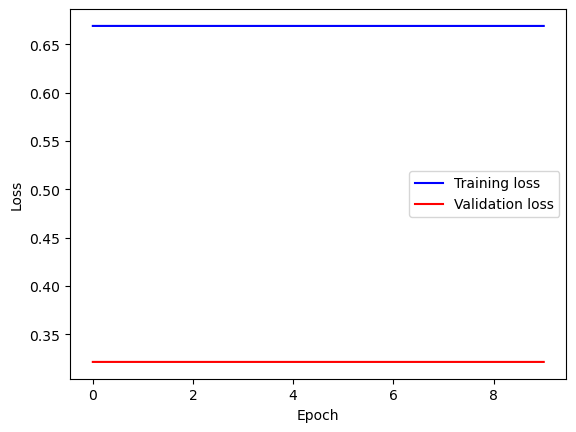

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# save the checkpoint model training
output_path = "../models/"

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, Path(output_path,'transformer_train_checkpoint.pt'))

#### Evaluate model
Now we can evaluate our model with testing set and compare the predictions with the ground truth.

In [27]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = torch.autograd.Variable(X_batch).to(device)
    var_y_batch = torch.autograd.Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch, var_X_batch.detach().clone()[:,-1:,:])
        loss = criterion(output, var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(torch.mean(output.squeeze(), dim=1).cpu().detach().numpy())
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

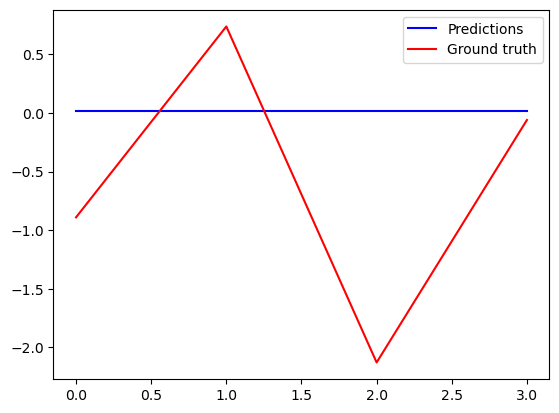

In [34]:
fig = plt.figure()
instances = np.arange(len(predictions[0]))
plt.scatter(instances, predictions[0], label="Predictions")
plt.scatter(instances, np.mean(test_y_torch.squeeze().numpy(), 1), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()